In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys, time, json, copy
import matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /Users/sunao-mac/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


# Year 1, single source bin analysis

In [4]:
%%time
dirname = './single_source_ClY1'
x,y,y_dict,cov, pnames, F = hsc3x2pt.getFisherMat(dirname, power_b1)

CPU times: user 5.96 s, sys: 404 ms, total: 6.36 s
Wall time: 3.42 s


In [5]:
fisher = hsc3x2pt.Fisher_class(F)

In [6]:
for i, pname in enumerate(pnames):
    s = fisher.get1DSigma(i)
    print(f'{pname:<15} {s}')

omega_b         0.03450334225976519
omega_c         0.07313345698008213
Omega_de        0.014526491791370166
n_s             0.10633810685253466
ln10p10As       0.4948429762307077
b1lowz          0.34159058676751825
b1cmass1        0.22153820771892088
b1cmass2        0.22975031809176
alphamaglowz    65.33857388594673
alphamagcmass1  5.982145067756775
alphamagcmass2  4.349090871111551
dzph            0.4289202342417763
dm              0.40852712376713385


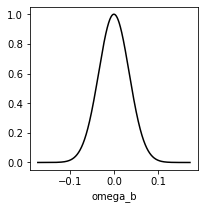

In [11]:
fisher._plot1d(0, xlabel='omega_b')

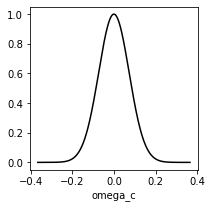

In [32]:
fisher._plot1d(1, xlabel='omega_c')

using dark_emulator at  /Users/sunao-mac/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


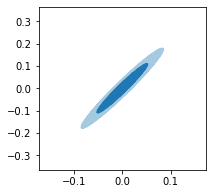

In [39]:
ans = fisher._plot2d(0, 1, color='C0')

In [ ]:
fig = plt.figure()

In [25]:
x,y,P,levels = ans

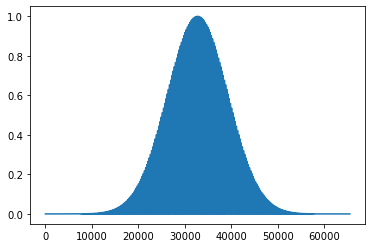

In [28]:
plt.figure()
plt.plot(P.reshape(-1))
plt.show()

In [29]:
P.shape

(256, 256)

In [19]:
ans = fisher.get1DDensity(0)
d = ans

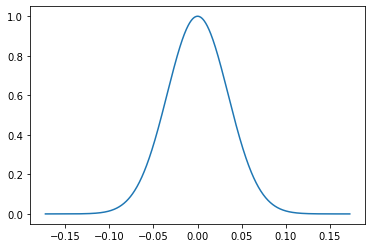

In [20]:
plt.figure()
plt.plot(d.x, d.P)
plt.show()

In [51]:
d = fisher.get2DDensity(0, 1)

(256, 256)

In [49]:
plt.subplots(1,1)

15455.457718810532

In [60]:
a = np.arange(10)
print(a)
args = np.argsort(a)[::-1]

[0 1 2 3 4 5 6 7 8 9]


In [63]:
np.argmax(a)

9

In [6]:
pk2cl_fid = hsc3x2pt.pk2cl_class(power_b1)
pk2cl_fid.load_Cl_cache(os.path.join(dirname, 'fiducial'))

In [7]:
x = hsc3x2pt.radial_bin_class(pk2cl_fid.get_all_galaxy_sample())

In [8]:
cov = hsc3x2pt.covariance_class(x)
cov.set_covariance_from_pk2cl(pk2cl_fid)
c = cov.get_full_covariance()
cc = hsc3x2pt.correlation_coeff(c)
ic = np.linalg.inv(c)

In [9]:
y = hsc3x2pt.signal_class(x)
y.set_signal_from_pk2cl(pk2cl_fid)
v_fid = y.get_signal()

In [10]:
F = getFisherMat(dirname, power_b1, ic, v_fid)

In [55]:
n = 6
F = np.arange(n**2).reshape((n,n))

In [56]:
fisher = hsc3x2pt.Fisher_class(F)

In [57]:
F11, F12, F21, F22 = fisher.devideIntoSubMat([0])

In [60]:
iF22 = np.linalg.inv(F22)
F11 - np.dot(F12, np.dot(iF22, F21))

array([[-10.]])

In [68]:
fisher.get1DSigma(4)

LinAlgError: Singular matrix

In [26]:
F

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [27]:
F[:1, :].T[:1,:].T

array([[0]])

In [28]:
F[1:, :].T[1:, :].T

array([[ 7,  8,  9, 10, 11],
       [13, 14, 15, 16, 17],
       [19, 20, 21, 22, 23],
       [25, 26, 27, 28, 29],
       [31, 32, 33, 34, 35]])

In [34]:
F[:1, :].T[1:].T

array([[1, 2, 3, 4, 5]])

In [30]:
F[1:, :].T[:1,:].T

array([[ 6],
       [12],
       [18],
       [24],
       [30]])